In [12]:
import re
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')  


lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # Remove all non-alphabet characters
    tokens = word_tokenize(text)  # Tokenization
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  # Lemmatization & stopword removal
    return ' '.join(tokens)

df = pd.read_csv('example.csv')


df['cleaned_text'] = df['text'].apply(clean_text)

df.to_csv('cleaned_text.csv',index= False)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\prg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\prg\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\prg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\prg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Adding word embeddings to the text data as the negative_response 

In [13]:
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
from torch.utils.data import DataLoader, Dataset


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()  


class TextDataset(Dataset):
    def __init__(self, texts):
        self.texts = texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx]


def get_bert_embeddings(texts, batch_size=32):
    dataset = TextDataset(texts)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    all_embeddings = []
    with torch.no_grad():
        for batch in dataloader:
            inputs = tokenizer(batch, return_tensors='pt', padding=True, truncation=True, max_length=128)
            outputs = model(**inputs)
            embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()  # Mean Pooling
            all_embeddings.append(embeddings)

    return np.vstack(all_embeddings)


df['bert_embedding'] = list(get_bert_embeddings(df['cleaned_text'].tolist()))

In [14]:
df.to_csv('Data_with_bert_embeddings.csv',index=False)

In [15]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder


le = LabelEncoder()
df['sentiment_encoded'] = le.fit_transform(df['airline_sentiment'])


X_weather = df[['snowfall', 'wind_speed', 'precipitation', 'humidity', 'temperature']].values
X_bert = np.array(df['bert_embedding'].tolist())  
X_combined = np.hstack((X_weather, X_bert)) 

y = df['sentiment_encoded'].values 


In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)


model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)


print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.72      0.96      0.82       925
           1       0.61      0.26      0.37       348
           2       0.75      0.42      0.54       266

    accuracy                           0.71      1539
   macro avg       0.69      0.55      0.58      1539
weighted avg       0.70      0.71      0.67      1539



In [19]:
from xgboost import XGBClassifier
model_xg_Boost = XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)
model_xg_Boost.fit(X_train, y_train)


y_pred_xgboost = model_xg_Boost.predict(X_test)


In [20]:
print(classification_report(y_pred_xgboost, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93      1124
           1       0.78      0.60      0.68       196
           2       0.91      0.63      0.75       219

    accuracy                           0.88      1539
   macro avg       0.86      0.73      0.78      1539
weighted avg       0.88      0.88      0.87      1539



Complaints Increasing Under Extreme Weather

Convert weather variables into "severe" and "normal" conditions.
Compare the complaint volume on severe vs. normal days.

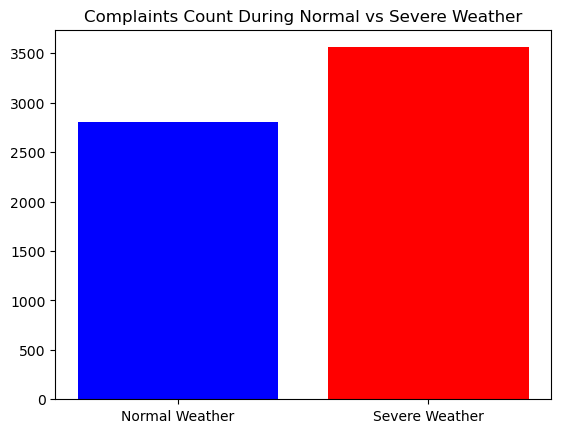

In [ ]:
import numpy as np


df['severe_weather'] = ((df['precipitation'] > df['precipitation'].quantile(0.5)) |
                        (df['snowfall'] > df['snowfall'].quantile(0.5)) |
                        (df['wind_speed'] > df['wind_speed'].quantile(0.5)))


complaints_by_weather = df.groupby('severe_weather')['tweet_id'].count()

# Plot
import matplotlib.pyplot as plt
labels = ['Normal Weather', 'Severe Weather']
plt.bar(labels, complaints_by_weather, color=['blue', 'red'])
plt.title("Complaints Count During Normal vs Severe Weather")
plt.show()

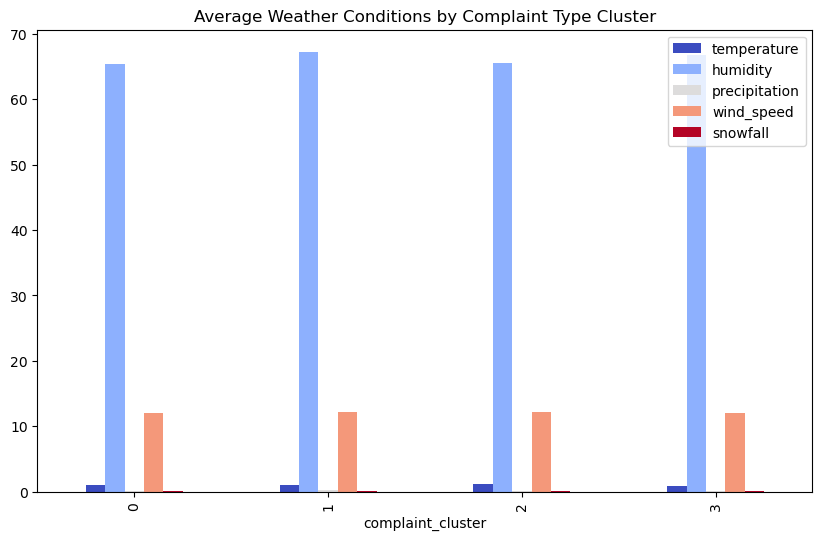

In [ ]:
from sklearn.cluster import KMeans
import pandas as pd

kmeans = KMeans(n_clusters=4, random_state=42)
df['complaint_cluster'] = kmeans.fit_predict(list(df['bert_embedding']))


cluster_weather = df.groupby('complaint_cluster')[['temperature', 'humidity', 'precipitation', 'wind_speed', 'snowfall']].mean()

cluster_weather.plot(kind='bar', figsize=(10,6), colormap='coolwarm')
plt.title("Average Weather Conditions by Complaint Type Cluster")
plt.show()


From the graph you can see most of the complaints are due to humidity and humidity plays a majour factor in flight being late 

Cluster Complaints Based on Weather & Text Similarity

Perform t-SNE on BERT embeddings and color by weather severity.

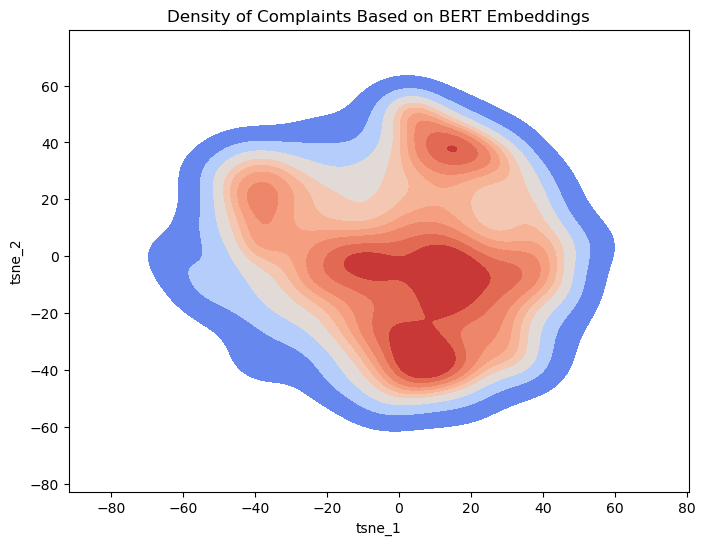

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.kdeplot(x=df['tsne_1'], y=df['tsne_2'], fill=True, cmap="coolwarm")
plt.title("Density of Complaints Based on BERT Embeddings")
plt.show()


From the above plot we can see that most of the Bert embeddingss are more related.